<a href="https://colab.research.google.com/github/bryankolaczkowski/gmcdp/blob/main/examples/ibd/ibd_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# read csv data

The pandas library will import a csv-formatted text file into a pandas DataFrame object.

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/bryankolaczkowski/gmcdp/main/examples/ibd/data_normalized.csv")
df.head()

,ID,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,ASV_11,ASV_12,ASV_14,ASV_15,ASV_16,ASV_17,ASV_18,ASV_19,ASV_20,ASV_21,ASV_23,ASV_24,ASV_25,ASV_27,ASV_28,ASV_30,ASV_31,ASV_32,ASV_33,ASV_34,ASV_35,ASV_36,ASV_37,ASV_40,ASV_41,ASV_44,ASV_45,ASV_46,ASV_47,...,ASV_128,ASV_131,ASV_132,ASV_135,ASV_138,ASV_139,ASV_141,ASV_144,ASV_145,ASV_148,ASV_160,ASV_164,ASV_166,ASV_169,ASV_170,ASV_173,ASV_175,ASV_183,ASV_189,ASV_193,ASV_197,ASV_202,ASV_203,ASV_209,ASV_211,ASV_219,ASV_222,ASV_224,ASV_225,ASV_246,ASV_254,ASV_273,ASV_274,ASV_276,ASV_293,ASV_308,ASV_319,ASV_351,ASV_352,Group
0,206700,2.344284,1.496287,11.762488,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,9.745637,0.000000,9.124915,0.000000,8.069177,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,11.870783,4.682153,0.000000,0.000000,9.271733,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,1.496287,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,7.113938,0.000000,0.0,2.697921,0.000000,0.000000,0.000000,2.081249,1.981714,0.000000,0.000000,0.000000,6.057002,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,2.981714,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,CD
1,206701,5.343217,0.000000,13.347146,3.937225,0.0,0.000000,0.000000,0.000000,3.863224,3.315737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.615297,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,4.615297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,6.64872,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,CD
2,206702,5.451885,0.000000,14.584537,4.992454,0.0,0.000000,3.477880,0.000000,3.477880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.670526,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3.477880,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,CD
3,206703,8.707199,5.565882,3.734005,2.488698,0.0,3.288929,0.000000,3.625071,0.215680,1.056982,3.281769,5.407150,3.770269,4.785535,2.596502,5.410437,0.0,5.777922,7.172782,2.619402,4.669636,5.018735,2.739242,3.810626,5.662763,1.630717,0.0,-0.199358,0.000000,2.780464,1.584914,0.0,2.412077,0.0,2.344963,0.0,0.0,3.739242,0.0,...,0.0,1.513360,1.122570,0.0,-0.047355,-0.281820,2.820542,1.630717,0.0,0.0,0.215680,0.000000,1.090149,0.0,-0.462392,1.760000,-2.369283,0.878645,-0.369283,0.000000,-1.784320,0.000000,-0.668843,-2.047355,0.0,0.630717,0.0,0.0,-1.561928,0.00000,0.0,0.000000,-1.047355,0.0,-0.047355,0.0,0.000000,-0.909851,-0.369283,Control
4,206704,7.438783,6.128443,3.934198,2.132743,0.0,3.010955,2.462892,4.018411,0.276479,1.118938,2.349235,6.454671,4.699269,4.916350,3.319365,5.605850,0.0,5.422718,5.837405,1.793537,4.446404,5.768332,2.146418,4.879977,6.315587,2.238677,0.0,0.000000,0.000000,4.229069,1.395778,0.0,3.003460,0.0,2.451921,0.0,0.0,3.139597,0.0,...,0.0,1.325388,1.568245,0.0,2.018411,2.159965,2.484587,0.740426,0.0,0.0,1.090923,0.000000,-0.774147,0.0,-0.674612,2.802202,-1.996540,2.212914,0.173385,0.000000,-0.259574,-1.122071,-2.259574,-1.259574,0.0,0.372694,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.276479,0.0,1.146418,-0.774147,-1.774147,Control


# extract ASV data to numpy

Numpy "N-dimensional arrays" (aka, "tensors") are a standard way to 'translate' data between different python libraries.

In this case, we first extract all the columns from the DataFrame whose headers start with "ASV_", which indicates that the column contains abundance data (aka, the explanatory variables).

In [2]:
asvs = [ x for x in df.columns if x.find('ASV_') == 0]
x = df[asvs].to_numpy()
x

array([[ 2.34428375,  1.49628684, 11.76248776, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.34321726,  0.        , 13.34714614, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.45188524,  0.        , 14.58453686, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [11.14288092,  9.4783444 ,  8.78667031, ...,  0.        ,
         0.        ,  0.        ],
       [10.73384005,  9.89028792,  9.5653231 , ...,  0.        ,
         0.        ,  0.        ],
       [10.63501957,  9.61990614,  9.066243  , ...,  0.        ,
         0.        ,  0.        ]])

# extract disease state data to numpy

We'll also need the response variable, which is stored in the column called "Group". In this case, the response variable is a binary indicating whether the sample (row) is from an individual diagnosed with the disease, or not.

In the DataFrame, disease-diagnosed rows are indicated by Group="CD", and non-diagnosed rows are indicated by Group="Control". We translate these labels to 0|1, using a python Dictionary (map).

Response variables are also translated to a Numpy array.

In [21]:
import numpy as np

c = df[['Group']]
c = c.to_numpy().ravel()
map = { 'CD':1, 'Control':0 }
yl = [ map[x] for x in c]
y = np.array(yl)
y

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1])

# package expanatory,response variables for tensorflow

Tensorflow can read Numpy arrays containing explanatory and response variables into a Dataset object that can be used to efficiently train neural networks.

It's a bit difficlt to 'look at' the contents of the Dataset object, directly (although you can re-convert the Dataset to numpy arrays). The "shape" of the explanatory (x) and response (y) tensors includes a "batch dimension" (None), which will be 'filled in' by tensorflow during training, based on the specified 'batch size' of the Dataset (in this case, 10).

In [4]:
import tensorflow as tf

data = tf.data.Dataset.from_tensor_slices((x,y)).shuffle().batch(10)
data

<BatchDataset shapes: ((None, 130), (None,)), types: (tf.float64, tf.int64)>

# data visualization

XX

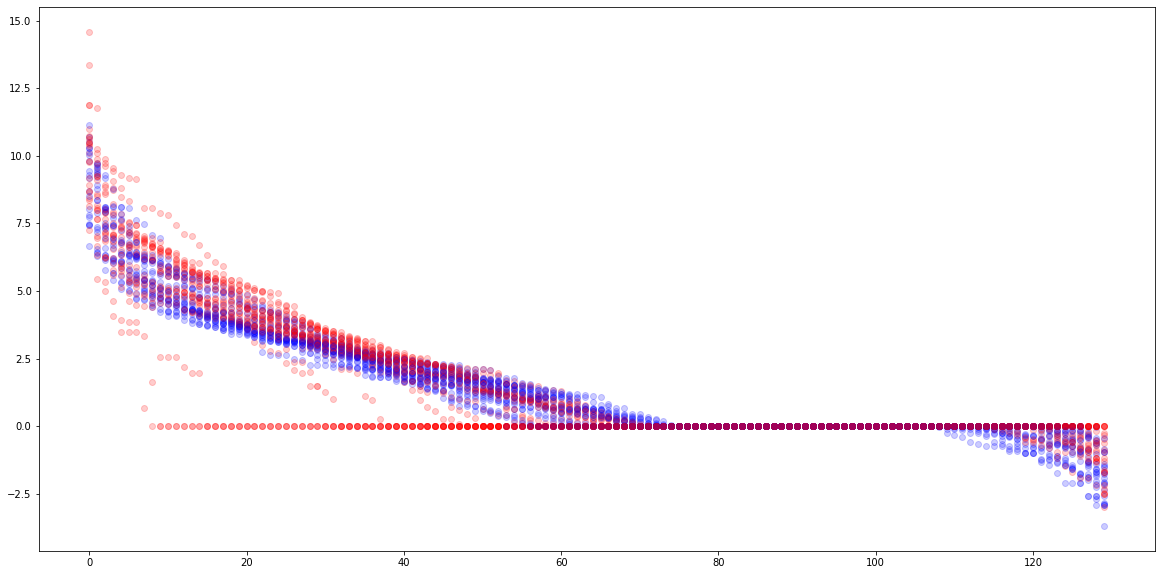

In [9]:
import matplotlib
import matplotlib.pyplot as plt

cmap = ['blue', 'red']

fig,ax = plt.subplots(1,1, figsize=(20,10))

xax = np.arange(0, x.shape[-1], 1)

for j in range(x.shape[0]):
  yax = np.array(x[j,:])
  yax = np.flip(np.sort(yax))
  ax.scatter(xax, yax, color=cmap[y[j]], alpha=0.2)

In [34]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(130,)))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=100, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_5 (Dropout)          (None, 130)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               13100     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(data, epochs=100)

Epoch 1/100
5/5 [==============================] - 0s 3ms/step - loss: 1.5481 - acc: 0.5116
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 1.0134 - acc: 0.6279
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.9048 - acc: 0.6279
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.4956 - acc: 0.8140
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 1.0156 - acc: 0.6744
Epoch 6/100
5/5 [==============================] - 0s 2ms/step - loss: 0.4180 - acc: 0.7674
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.2579 - acc: 0.8605
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.4947 - acc: 0.8605
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1898 - acc: 0.8837
Epoch 10/100
5/5 [==============================] - 0s 2ms/step - loss: 0.4231 - acc: 0.8140
Epoch 11/100
5/5 [==============================] - 0s 3ms/step - loss: 0.3531 